Device: cuda
Classes: {'Normal': 0, 'Bleeding': 1, 'Ischemia': 2}
Found 4427 images for class 'Normal' in D:\Python\Projects\Brain Stroke CT\ozguraslank\brain-stroke-ct-dataset\versions\3\Brain_Stroke_CT_Dataset\Normal\PNG\*.png
Found 1093 images for class 'Bleeding' in D:\Python\Projects\Brain Stroke CT\ozguraslank\brain-stroke-ct-dataset\versions\3\Brain_Stroke_CT_Dataset\Bleeding\PNG\*.png
Found 1130 images for class 'Ischemia' in D:\Python\Projects\Brain Stroke CT\ozguraslank\brain-stroke-ct-dataset\versions\3\Brain_Stroke_CT_Dataset\Ischemia\PNG\*.png
Final dataset class counts: Counter({np.int64(0): 4427, np.int64(2): 1130, np.int64(1): 1093})
Balanced (limited) dataset class counts: Counter({np.int64(0): 4427, np.int64(2): 1130, np.int64(1): 1093})
Using 6650 images.
Using existing memmap cache.
Stratified sampled class counts: Counter({np.int64(0): 4427, np.int64(2): 1130, np.int64(1): 1093})
Train class counts: Counter({np.int64(0): 3542, np.int64(2): 904, np.int64(1): 874})
V

Epoch 01/10 | train_loss 0.4791 train_acc 0.8126 | val_loss 0.2703 val_acc 0.9038 | 59.7s
 ↳ new best saved: ./ct_memmap_cache\best_resnet18.pt (val_acc=0.9038)


Epoch 02/10 | train_loss 0.2918 train_acc 0.8930 | val_loss 0.2047 val_acc 0.9165 | 51.3s
 ↳ new best saved: ./ct_memmap_cache\best_resnet18.pt (val_acc=0.9165)


Epoch 03/10 | train_loss 0.1835 train_acc 0.9344 | val_loss 0.1688 val_acc 0.9376 | 51.1s
 ↳ new best saved: ./ct_memmap_cache\best_resnet18.pt (val_acc=0.9376)


Epoch 04/10 | train_loss 0.1595 train_acc 0.9417 | val_loss 0.1666 val_acc 0.9361 | 51.3s


Epoch 05/10 | train_loss 0.1608 train_acc 0.9429 | val_loss 0.1526 val_acc 0.9466 | 51.2s
 ↳ new best saved: ./ct_memmap_cache\best_resnet18.pt (val_acc=0.9466)


Epoch 06/10 | train_loss 0.2149 train_acc 0.9241 | val_loss 0.1596 val_acc 0.9459 | 50.5s


Epoch 07/10 | train_loss 0.1919 train_acc 0.9342 | val_loss 0.1750 val_acc 0.9398 | 53.2s


Epoch 08/10 | train_loss 0.1350 train_acc 0.9515 | val_loss 0.1627 val_acc 0.9474 | 66.9s
 ↳ new best saved: ./ct_memmap_cache\best_resnet18.pt (val_acc=0.9474)


Epoch 09/10 | train_loss 0.0820 train_acc 0.9731 | val_loss 0.1136 val_acc 0.9579 | 67.3s
 ↳ new best saved: ./ct_memmap_cache\best_resnet18.pt (val_acc=0.9579)


Epoch 10/10 | train_loss 0.0795 train_acc 0.9707 | val_loss 0.1153 val_acc 0.9594 | 67.2s
 ↳ new best saved: ./ct_memmap_cache\best_resnet18.pt (val_acc=0.9594)

Loading best model for evaluation...



Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       885
    Bleeding       0.93      0.95      0.94       219
    Ischemia       0.94      0.85      0.90       226

    accuracy                           0.96      1330
   macro avg       0.95      0.93      0.94      1330
weighted avg       0.96      0.96      0.96      1330



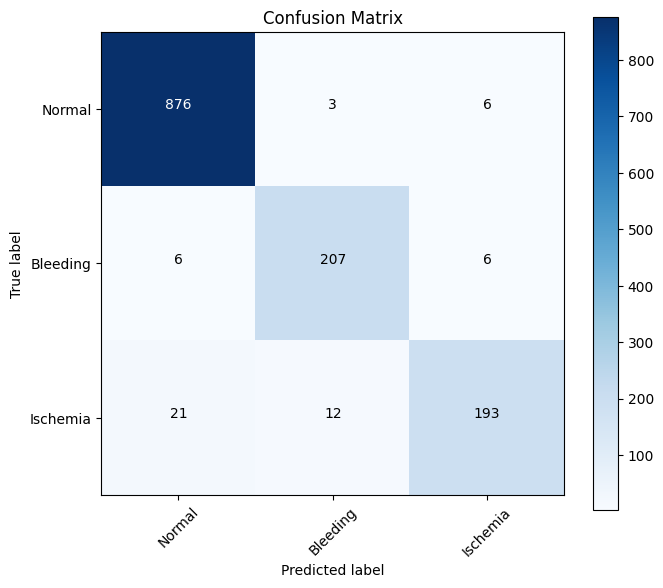

In [1]:
# =========================
# ⚡ Setup & Imports
# =========================
import os
import json
import glob
import time
import random
from pathlib import Path
from collections import Counter

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
import cv2
cv2.setNumThreads(0)

# -------- Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # safer but slower
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================
# 📂 Paths & Classes
# =========================
dataset_root = r"D:\Python\Projects\Brain Stroke CT\ozguraslank\brain-stroke-ct-dataset\versions\3\Brain_Stroke_CT_Dataset"
work_dir = "./ct_memmap_cache"
Path(work_dir).mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224, 224)  # H, W
class_names = ["Normal", "Bleeding", "Ischemia"]
class_to_idx = {cls: i for i, cls in enumerate(class_names)}
print("Classes:", class_to_idx)

# =========================
# 🧰 Dataset scan with logging and validation
# =========================
def scan_pngs(root, class_to_idx):
    files, labels = [], []
    for cls in class_to_idx:
        pattern = os.path.join(root, cls, "PNG", "*.png")
        paths = sorted(glob.glob(pattern))
        print(f"Found {len(paths)} images for class '{cls}' in {pattern}")
        if len(paths) == 0:
            raise RuntimeError(f"No images found for class '{cls}'. Check dataset folder and naming.")
        files.extend(paths)
        labels.extend([class_to_idx[cls]] * len(paths))
    return files, np.array(labels, dtype=np.int64)

all_files, all_labels = scan_pngs(dataset_root, class_to_idx)

print("Final dataset class counts:", Counter(all_labels))

print("Balanced (limited) dataset class counts:", Counter(all_labels))

# Limit dataset size for testing (optional)


LIMIT_PER_CLASS = len(all_files)  # or any number ≤ min class size (e.g. 1000 ≤ 1093, 1130)

files_by_class = defaultdict(list)
for filepath, label in zip(all_files, all_labels):
    files_by_class[label].append(filepath)

balanced_files, balanced_labels = [], []
for label, files in files_by_class.items():
    selected = files[:LIMIT_PER_CLASS]  # Could also shuffle before slicing
    balanced_files.extend(selected)
    balanced_labels.extend([label] * len(selected))

# Shuffle all together to avoid class-wise ordering
combined = list(zip(balanced_files, balanced_labels))
random.shuffle(combined)
balanced_files, balanced_labels = zip(*combined)

all_files = list(balanced_files)
all_labels = np.array(balanced_labels, dtype=np.int64)

# ✅ Define N before using it
N = len(all_files)
assert N > 0, "No images found!"
print(f"Using {N} images.")


# =========================
# 🧱 Preprocessing: memmap cache creation
# =========================
imgs_npy = os.path.join(work_dir, f"images_{IMG_SIZE[0]}x{IMG_SIZE[1]}_uint8.npy")
labels_npy = os.path.join(work_dir, "labels_int64.npy")
meta_path = os.path.join(work_dir, "meta.json")

need_preprocess = not (os.path.exists(imgs_npy) and os.path.exists(labels_npy) and os.path.exists(meta_path))

if need_preprocess:
    print("Preprocessing images to memmap cache...")
    t0 = time.time()

    imgs_mm = np.lib.format.open_memmap(imgs_npy, mode="w+", dtype=np.uint8, shape=(N, IMG_SIZE[0], IMG_SIZE[1], 3))
    labels_mm = np.lib.format.open_memmap(labels_npy, mode="w+", dtype=np.int64, shape=(N,))

    for i, (p, lbl) in enumerate(zip(all_files, all_labels)):
        img = cv2.imread(p, cv2.IMREAD_COLOR)
        if img is None:
            raise RuntimeError(f"Failed to read image: {p}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_AREA)
        imgs_mm[i] = img
        labels_mm[i] = lbl

        if (i + 1) % 500 == 0 or (i + 1) == N:
            print(f"  Processed {i + 1}/{N}")

    # Save meta info for record keeping
    with open(meta_path, "w") as f:
        json.dump({
            "num_images": N,
            "img_h": IMG_SIZE[0],
            "img_w": IMG_SIZE[1],
            "channels": 3,
            "classes": class_names,
            "class_to_idx": class_to_idx
        }, f, indent=2)

    print(f"Preprocessing done in {time.time() - t0:.1f}s")
else:
    print("Using existing memmap cache.")

# =========================
# 📖 Dataset Classes
# =========================
class CTMemmapDataset(Dataset):
    def __init__(self, imgs_path, labels_path, augment=False):
        self.imgs = np.load(imgs_path, mmap_mode="r")
        self.labels = np.load(labels_path, mmap_mode="r")
        self.augment = augment

        aug_list = []
        if augment:
            aug_list += [
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
            ]

        self.tf = transforms.Compose(aug_list + [
            transforms.ToTensor(),  # Converts PIL Image or numpy.ndarray to tensor (C,H,W) and scales [0,255]->[0,1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        img_np = self.imgs[idx]  # uint8 HWC numpy array
        label = int(self.labels[idx])
        img_pil = Image.fromarray(img_np)
        img_tensor = self.tf(img_pil)
        return img_tensor, label

class IndexedCTDataset(Dataset):
    def __init__(self, base_dataset: CTMemmapDataset, indices: np.ndarray):
        self.base = base_dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        return self.base[self.indices[i]]

# =========================
# ✂ Train/Val Stratified Split
# =========================
def stratified_split(labels, val_ratio=0.2, seed=42):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=seed)
    indices = np.arange(len(labels))
    for train_idx, val_idx in sss.split(indices, labels):
        return train_idx, val_idx

train_idx, val_idx = stratified_split(all_labels, val_ratio=0.2)
print("Stratified sampled class counts:",
      Counter(all_labels))
print("Train class counts:", Counter(all_labels[train_idx]))
print("Val class counts:  ", Counter(all_labels[val_idx]))
print(f"Train: {len(train_idx)} | Val: {len(val_idx)}")

# =========================
# 📂 Dataset & DataLoader creation
# =========================
base_train = CTMemmapDataset(imgs_npy, labels_npy, augment=True)
base_val = CTMemmapDataset(imgs_npy, labels_npy, augment=False)

train_ds = IndexedCTDataset(base_train, train_idx)
val_ds = IndexedCTDataset(base_val, val_idx)

# Set start method for multiprocessing (safe)
import multiprocessing as mp
mp.set_start_method("spawn", force=True)

BATCH_SIZE = 16
NUM_WORKERS = 0  # increase if enough CPU cores and no memory issues

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)

# =========================
# 🧠 Model, Criterion, Optimizer, Scheduler
# =========================
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3)

# =========================
# 🔁 Train and Validate Functions
# =========================
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    loop = tqdm(loader, desc="Train" if train else "Val", leave=False)
    for xb, yb in loop:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            out = model(xb)
            loss = criterion(out, yb)
            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item()
        preds = out.argmax(dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.detach().cpu().numpy())

        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc, np.array(all_preds), np.array(all_labels)

# =========================
# 🎯 Training Loop
# =========================
EPOCHS = 10
best_val_acc = 0.0
best_model_path = os.path.join(work_dir, "best_resnet18.pt")

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    train_loss, train_acc, _, _ = run_epoch(train_loader, train=True)
    val_loss, val_acc, val_preds, val_labels = run_epoch(val_loader, train=False)

    scheduler.step()

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss {train_loss:.4f} train_acc {train_acc:.4f} | "
          f"val_loss {val_loss:.4f} val_acc {val_acc:.4f} | "
          f"{time.time()-t0:.1f}s")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f" ↳ new best saved: {best_model_path} (val_acc={val_acc:.4f})")

# =========================
# 📝 Evaluation & Reporting
# =========================
print("\nLoading best model for evaluation...")
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Predict on val set again
_, _, val_preds, val_labels = run_epoch(val_loader, train=False)

# Classification report
print("\nClassification Report:")
print(classification_report(
    val_labels,
    val_preds,
    target_names=class_names,
    labels=[0, 1, 2],  # explicitly define all expected classes
    zero_division=0    # optional: avoid warnings for missing classes
))

# Confusion matrix plot
cm = confusion_matrix(val_labels, val_preds, labels=list(range(len(class_names))))

plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()





In [2]:
# In your training script
# ...
torch.save(model.state_dict(), best_model_path)
print(f" ↳ new best saved: {best_model_path} (val_acc={val_acc:.4f})")

 ↳ new best saved: ./ct_memmap_cache\best_resnet18.pt (val_acc=0.9594)
